In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers, Model
from model_implementations import cnn3
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, convolve1d
from IPython.display import clear_output

In [2]:
if tf.config.list_physical_devices('GPU'):
    # enable memory growth instead of blocking whole VRAM
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.utils.set_random_seed(2022)

2022-08-27 12:40:28.500985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.501215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.523492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.523725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.524392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
datapoints = 500
cl1 = .8
cl2 = .6
var = .1

nt = 500
nv = 200

xt = np.zeros([nt*2, datapoints])
xv = np.zeros([nv*2, datapoints])

peak_shapes = (2,8)
rng = np.random.default_rng(2022)
for i in range(nt):
    temp = np.zeros(datapoints)
    temp_val = cl1 + rng.uniform(-var, var)
    temp[rng.integers(200,300)] = 1.
    temp_cont = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                  mode='constant')
    xt[i] = temp_cont / np.max(temp_cont) * temp_val
    temp = np.zeros(datapoints)
    temp_val = cl2 + rng.uniform(-var, var)
    temp[rng.integers(200,300)] = 1.
    temp_cont = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                  mode='constant')
    xt[nt+i] = temp_cont / np.max(temp_cont) * temp_val
for i in range(nv):
    temp = np.zeros(datapoints)
    temp_val = cl1 + rng.uniform(-var, var)
    temp[rng.integers(200,300)] = 1.
    temp_cont = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                  mode='constant')
    xv[i] = temp_cont / np.max(temp_cont) * temp_val
    temp = np.zeros(datapoints)
    temp_val = cl2 + rng.uniform(-var, var)
    temp[rng.integers(200,300)] = 1.
    temp_cont = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                  mode='constant')
    xv[nv+i] = temp_cont / np.max(temp_cont) * temp_val

In [4]:
yt = np.repeat(np.array([0,1]), nt, axis=0)
yv = np.repeat(np.array([0,1]), nv, axis=0)
yt_oh = tf.one_hot(yt, 2)
yv_oh = tf.one_hot(yv, 2)

2022-08-27 12:40:28.634594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 12:40:28.635307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.635915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 12:40:28.636424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

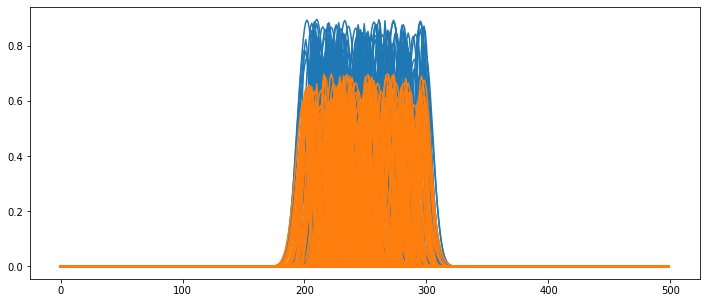

In [5]:
plt.figure(figsize=(12,5))
plt.plot(xv[:nv].T, c='C0')
plt.plot(xv[nv:].T, c='C1')
plt.show()

In [6]:
def generate_noise(spectra, cheb_coefs=(-0.05,0.05), noise_range=(0.02,0.05)):
    datapoints = spectra.shape[1]
    # background function using a chebyshev polynomial
    rng = np.random.default_rng(2022)
    cheb = np.zeros_like(spectra)
    for i in range(cheb.shape[0]):
        polynom_order = rng.integers(3,7)
        ccoefs = rng.uniform(cheb_coefs[0]/polynom_order, 
                             cheb_coefs[1]/polynom_order,
                             (polynom_order))
        c = np.polynomial.chebyshev.Chebyshev(ccoefs)
        cheb[i,:] = c.linspace(datapoints)[1]
    # correction to avoid negative background
    negative = np.min(cheb, axis=1) < 0
    cheb = cheb + (np.abs(np.min(cheb, axis=1)) * negative)[:,None]
    
    # gaussian noise -> dependent on signal
    # we want to avoid extreme outliers so we clip the noise
    # with 1/3 and -3/+3 we achieve a nice normal distribution for values -1 to 1
    gaus = 1/3 * np.clip(rng.normal(0, 1, spectra.shape), -3, 3)
    # next we shift the noise from -1 and 1 to 0 and 1
    gaus = (gaus*.5)+.5
    
    noise_lvl = rng.uniform(noise_range[0],noise_range[1], spectra.shape[0])
   
    # combining everything together
    noisy_scan = np.add(spectra,gaus*noise_lvl[:,None])
    noisy_scan += cheb
    return noisy_scan

In [7]:
xtn = generate_noise(xt)

In [8]:
plt.rcParams['font.size'] = 14

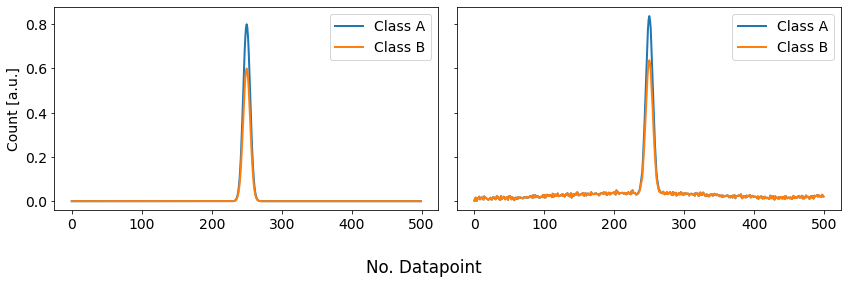

In [9]:
x1 = np.zeros(500)
x1[250] = 1.
x1 = gaussian_filter1d(x1, 5.,mode='constant')
x2 = x1 / np.max(x1) * .6
x1 = x1 / np.max(x1) * .8
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].plot(x1, lw=2, c='C0', label='Class A')
ax[0].plot(x2, lw=2, c='C1', label='Class B')
ax[1].plot(generate_noise(x1[None,:])[0], lw=2, c='C0', label='Class A')
ax[1].plot(generate_noise(x2[None,:])[0], lw=2, c='C1', label='Class B')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Count [a.u.]')
fig.supxlabel('No. Datapoint')
plt.tight_layout()
#plt.savefig('twoclass_spectra.png', dpi=500, bbox_inches='tight')
plt.show()

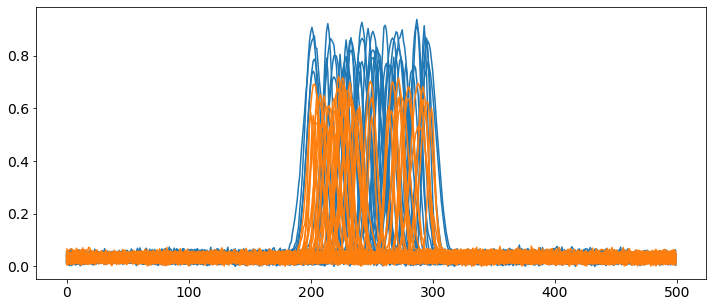

In [10]:
plt.figure(figsize=(12,5))
plt.plot(xtn[:nt:10].T, c='C0')
plt.plot(xtn[nt::10].T, c='C1')
plt.show()

In [11]:
pos_train = np.argmax(xtn, axis=1)
hi_train = np.max(xtn, axis=1)
pos_val = np.argmax(xv, axis=1)
hi_val = np.max(xv, axis=1)

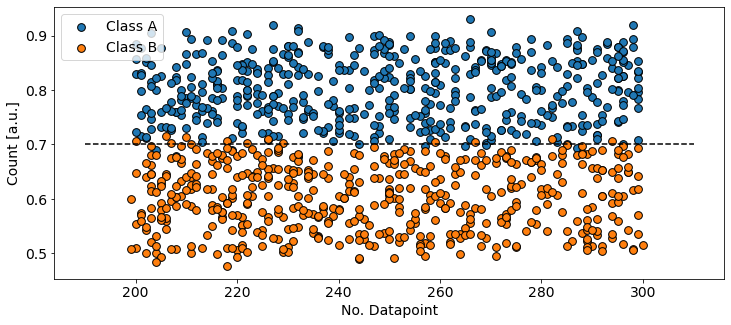

In [12]:
plt.figure(figsize=(12,5))
plt.scatter(pos_train[:nt], hi_train[:nt]-.03, s=60, edgecolors='black', c='C0', label='Class A')
plt.scatter(pos_train[nt:], hi_train[nt:]-.03, s=60, edgecolors='black', c='C1', label='Class B')
plt.plot([190,310],[.7,.7],'--', c='black')
plt.legend()
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
plt.show()
#plt.savefig('twoclass_points.png', dpi=500, bbox_inches='tight')

In [13]:
class CustomProg(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_val = 1e5
        self.best_epoch_no = 0
        self.best_log = ''
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < self.best_val:
            self.best_val = logs['val_loss']
            self.best_epoch_no = epoch
            self.best_log = ' - '.join(f'{k}: {round(v, 4)}' for k,v in logs.items())
        clear_output(wait=True)
        print(f'Epoch {epoch}:', ' - '.join(f'{k}: {round(v, 4)}' for k,v in logs.items()))
        print(f'Best {self.best_epoch_no}: {self.best_log}')

In [14]:
tf.keras.utils.set_random_seed(2022)
model = cnn3(input_size=500, dense_neurons=[], classes=2)
tf.keras.utils.set_random_seed(2022)
model.fit(xtn, yt_oh, batch_size=256, epochs=500, verbose=0, 
          callbacks=[CustomProg(), tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
          validation_data=(xv, yv_oh), shuffle=True)

Epoch 150: loss: 0.0535 - accuracy: 0.982 - val_loss: 0.0756 - val_accuracy: 0.9575
Best 140: loss: 0.0555 - accuracy: 0.982 - val_loss: 0.0718 - val_accuracy: 0.965


In [15]:
pred = model.predict(xv)
pred_cl = np.argmax(pred, axis=1)

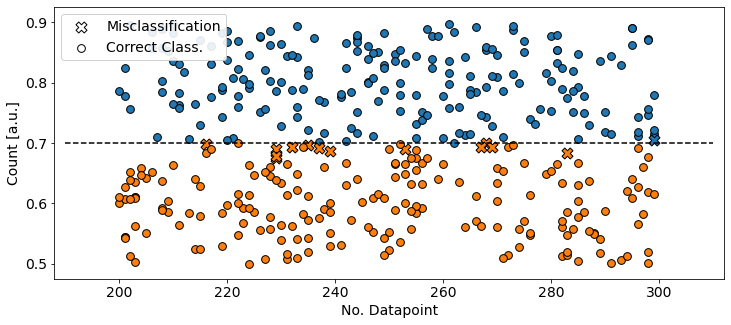

In [16]:
plt.figure(figsize=(12,5))
for i in range(nv*2):
    c = 'C0' if i < nv else 'C1'
    mkr,s = ('o',60) if pred_cl[i] == yv[i] else ('X',120)
    plt.scatter(pos_val[i], hi_val[i], c=c, marker=mkr, s=s, edgecolors='black')
plt.plot([190,310],[.7,.7],'--', c='black')
plt.scatter(0,0,marker='X', s=120, edgecolors='black', c='white', label='Misclassification')
plt.scatter(0,0,marker='o', s=60, edgecolors='black', c='white', label='Correct Class.')
plt.xlim(188,312)
plt.ylim(.475,.925)
plt.legend(loc=2, framealpha=.9)
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
plt.show()
#plt.savefig('twoclass_cnn_pred.png', dpi=500, bbox_inches='tight')

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier(min_samples_leaf=5, max_features=200, random_state=2022)

In [19]:
knn.fit(xtn, yt)
rf.fit(xtn, yt)

RandomForestClassifier(max_features=200, min_samples_leaf=5, random_state=2022)

In [20]:
knn.score(xv, yv)

0.775

In [21]:
rf.score(xv, yv)

0.8

In [22]:
pred_rf = rf.predict(xv)

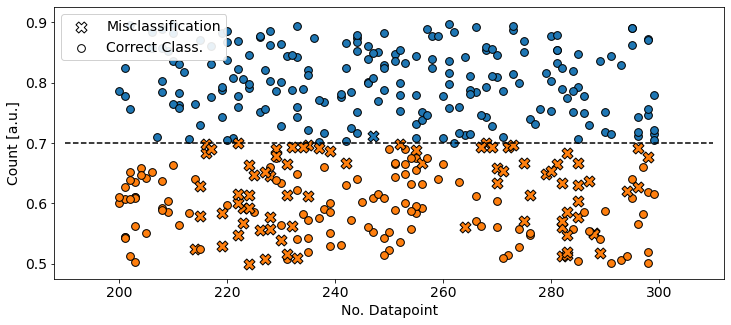

In [23]:
plt.figure(figsize=(12,5))
for i in range(nv*2):
    c = 'C0' if i < nv else 'C1'
    mkr,s = ('o',60) if pred_rf[i] == yv[i] else ('X',120)
    plt.scatter(pos_val[i], hi_val[i], c=c, marker=mkr, s=s, edgecolors='black')
plt.plot([190,310],[.7,.7],'--', c='black')
plt.scatter(0,0,marker='X', s=120, edgecolors='black', c='white', label='Misclassification')
plt.scatter(0,0,marker='o', s=60, edgecolors='black', c='white', label='Correct Class.')
plt.xlim(188,312)
plt.ylim(.475,.925)
plt.legend(loc=2, framealpha=.9)
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
plt.show()
#plt.savefig('twoclass_rf_pred.png', dpi=500, bbox_inches='tight')

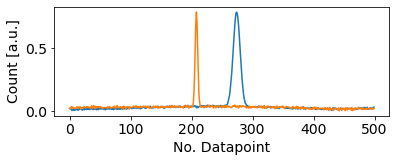

In [24]:
plt.figure(figsize=(6,2))
plt.plot(xtn[0])
plt.plot(xtn[84])
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
#plt.savefig('twosample_input.png', dpi=500, bbox_inches='tight')
plt.show()

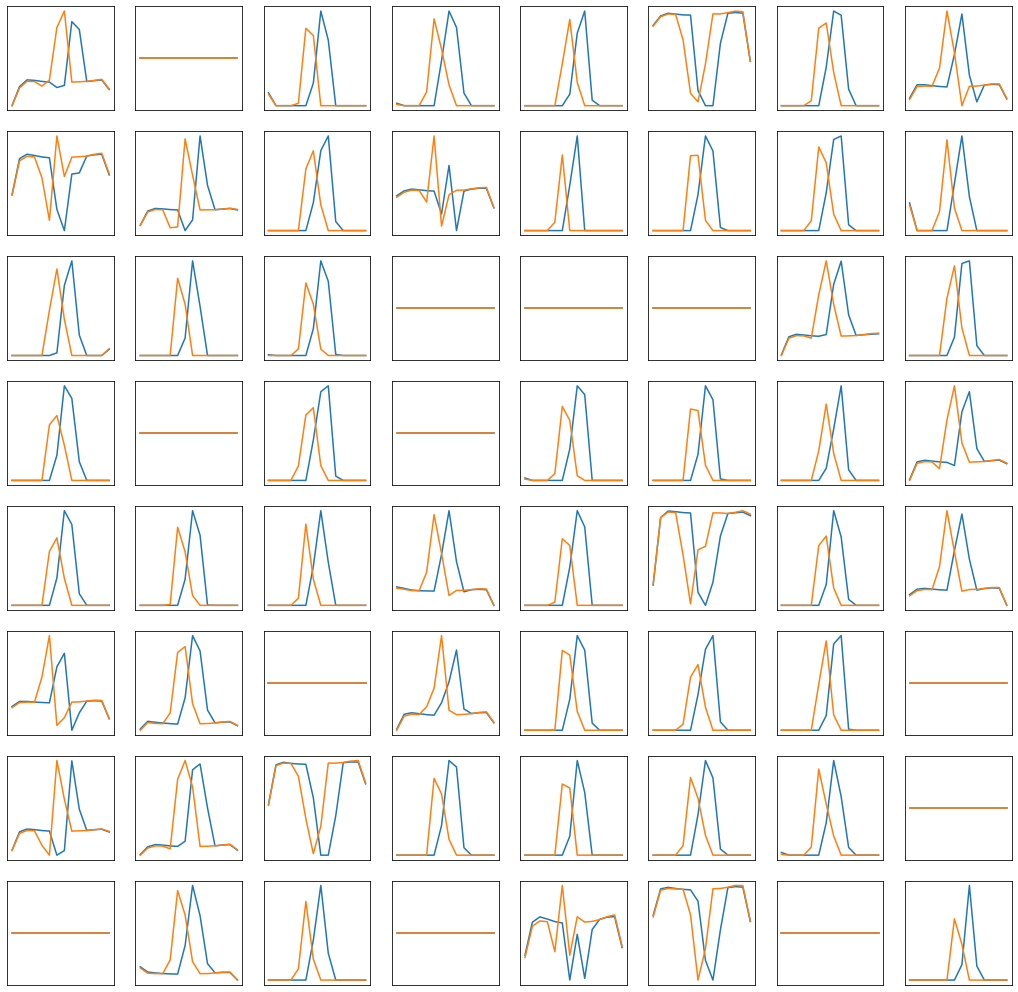

In [25]:
p3 = tf.keras.Model(model.input, model.layers[6].output).predict(xtn[[0,84]])
fig, ax = plt.subplots(8,8,figsize=(18,18))
ii = 0
for i in range(8):
    for j in range(8):
        ax[i,j].plot(p3[:,:,ii].T)
        ax[i,j].tick_params(axis='both', which='both', bottom=False, labelbottom=False,left=False, labelleft=False)
        ii += 1
#plt.savefig('twosample_actmaps.png', dpi=500, bbox_inches='tight')
plt.show()

In [26]:
def shrink_model1():
    input_layer = layers.Input(shape=(None, 1), 
                               name="input")
    x = layers.MaxPool1D(3, strides=3)(input_layer)
    out = layers.Flatten(name='flat')(x)
    model = Model(input_layer, out)
    return model

def shrink_model2():
    input_layer = layers.Input(shape=(None, 1), 
                               name="input")
    x = layers.MaxPool1D(3, strides=3)(input_layer)
    x = layers.MaxPool1D(3, strides=3)(x)
    out = layers.Flatten(name='flat')(x)
    model = Model(input_layer, out)
    return model

def shrink_model3():
    input_layer = layers.Input(shape=(None, 1), 
                               name="input")
    x = layers.MaxPool1D(3, strides=3)(input_layer)
    x = layers.MaxPool1D(3, strides=3)(x)
    x = layers.MaxPool1D(2, strides=2)(x)
    out = layers.Flatten(name='flat')(x)
    model = Model(input_layer, out)
    return model

In [27]:
xt_shrink1 = shrink_model1().predict(xtn)
xv_shrink1 = shrink_model1().predict(xv)
xt_shrink2 = shrink_model2().predict(xtn)
xv_shrink2 = shrink_model2().predict(xv)
xt_shrink3 = shrink_model3().predict(xtn)
xv_shrink3 = shrink_model3().predict(xv)

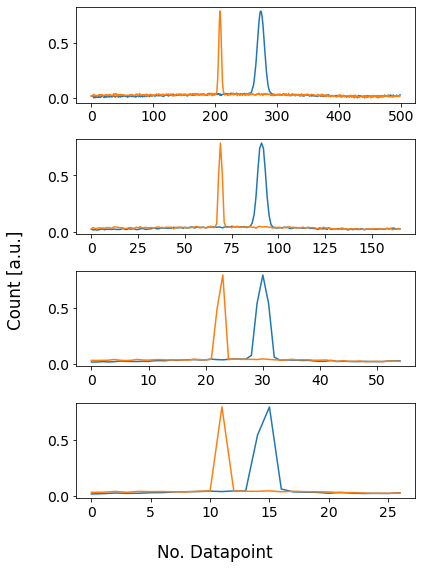

In [28]:
fig, ax = plt.subplots(4,1,figsize=(6,8))
ax[0].plot(xtn[[0,84]].T)
ax[1].plot(xt_shrink1[[0,84]].T)
ax[2].plot(xt_shrink2[[0,84]].T)
ax[3].plot(xt_shrink3[[0,84]].T)
fig.supylabel('Count [a.u.]')
fig.supxlabel('No. Datapoint')
plt.tight_layout()
#plt.savefig('twosample_pooling.png', dpi=500, bbox_inches='tight')
plt.show()

In [29]:
rf2 = RandomForestClassifier(min_impurity_decrease=0.02, random_state=2021)
rf2.fit(xt_shrink1, yt)
rf2.score(xv_shrink1, yv)

0.81

In [30]:
rf3 = RandomForestClassifier(min_impurity_decrease=0.02, random_state=2021)
rf3.fit(xt_shrink2, yt)
rf3.score(xv_shrink2, yv)

0.92

In [31]:
rf4 = RandomForestClassifier(min_impurity_decrease=0.02, random_state=2021)
rf4.fit(xt_shrink3, yt)
rf4.score(xv_shrink3, yv)

0.93

In [32]:
pred_rf4 = rf4.predict(xv_shrink3)

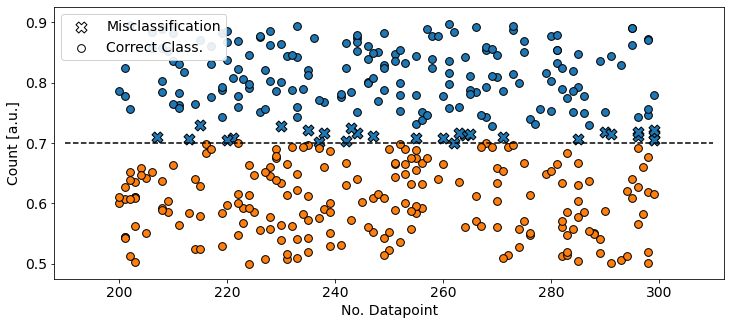

In [33]:
plt.figure(figsize=(12,5))
for i in range(nv*2):
    c = 'C0' if i < nv else 'C1'
    mkr,s = ('o',60) if pred_rf4[i] == yv[i] else ('X',120)
    plt.scatter(pos_val[i], hi_val[i], c=c, marker=mkr, s=s, edgecolors='black')
plt.plot([190,310],[.7,.7],'--', c='black')
plt.scatter(0,0,marker='X', s=120, edgecolors='black', c='white', label='Misclassification')
plt.scatter(0,0,marker='o', s=60, edgecolors='black', c='white', label='Correct Class.')
plt.xlim(188,312)
plt.ylim(.475,.925)
plt.legend(loc=2, framealpha=.9)
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
plt.show()
#plt.savefig('twoclass_rf_pred.png', dpi=500, bbox_inches='tight')

## Difference now due to background 
-> (learned thresholds are higher for training data than variation data)

In [34]:
xtc_shrink3 = shrink_model3().predict(xt)

In [35]:
rf5 = RandomForestClassifier(min_samples_leaf=10, random_state=2022)
rf5.fit(xtc_shrink3, yt)
rf5.score(xv_shrink3, yv)

0.99

In [36]:
pred_rf5 = rf5.predict(xv_shrink3)

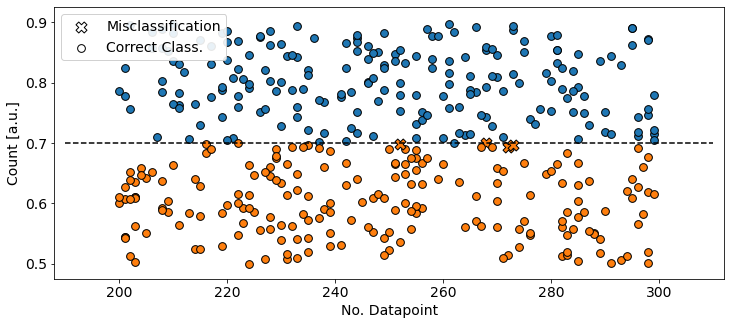

In [37]:
plt.figure(figsize=(12,5))
for i in range(nv*2):
    c = 'C0' if i < nv else 'C1'
    mkr,s = ('o',60) if pred_rf5[i] == yv[i] else ('X',120)
    plt.scatter(pos_val[i], hi_val[i], c=c, marker=mkr, s=s, edgecolors='black')
plt.plot([190,310],[.7,.7],'--', c='black')
plt.scatter(0,0,marker='X', s=120, edgecolors='black', c='white', label='Misclassification')
plt.scatter(0,0,marker='o', s=60, edgecolors='black', c='white', label='Correct Class.')
plt.xlim(188,312)
plt.ylim(.475,.925)
plt.legend(loc=2, framealpha=.9)
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
plt.show()

## Equal performance for CNN and traditional ML

In [38]:
def cnn_3(input_size=500, filters=64, dropout=.3, lr=3e-4):
    input_layer = layers.Input(shape=(input_size, 1), 
                               name="input")
    x = layers.Conv1D(filters, 20, strides=1, padding='same',
                      activation='relu', 
                      name='conv1')(input_layer)
    x = layers.MaxPool1D(3, strides=3, 
                         name='maxpool1')(x)
    x = layers.Conv1D(filters, 15, strides=1, padding='same',
                      activation='relu', 
                      name='conv2')(x)
    x = layers.MaxPool1D(2, strides=3, 
                         name='maxpool2')(x)
    x = layers.Conv1D(filters, 10, strides=2, padding='same',
                      activation='relu', 
                      name='conv3')(x)
    x = layers.MaxPool1D(1, strides=2, 
                         name='maxpool3')(x)
    x = layers.Flatten(name='flat')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(2, activation='softmax', 
                       name='output')(x)
    model = Model(input_layer, out)
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [39]:
model_start = []
model_end = []
for i in range(10):
    model = cnn_3(filters=1)
    model_start.append(model.get_weights())
    model.fit(xtn, yt, batch_size=256, epochs=500, verbose=0, 
              callbacks=[CustomProg(), tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)],
              validation_data=(xv, yv), shuffle=True)
    model_end.append(model.get_weights())

Epoch 499: loss: 0.4693 - sparse_categorical_accuracy: 0.81 - val_loss: 0.4975 - val_sparse_categorical_accuracy: 0.7075
Best 494: loss: 0.462 - sparse_categorical_accuracy: 0.826 - val_loss: 0.4902 - val_sparse_categorical_accuracy: 0.715


## CNN with single filter does not converge for some initializations

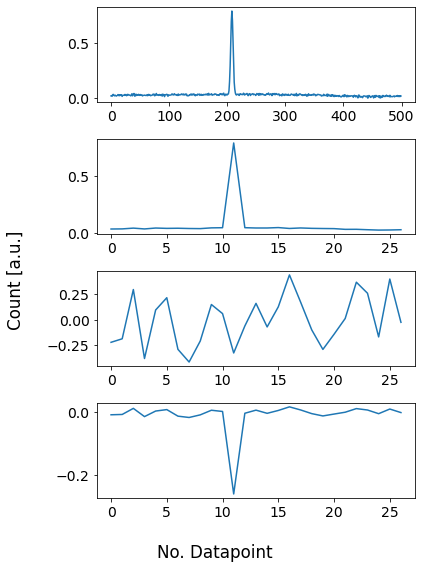

In [40]:
rng2 = np.random.default_rng(2)
limit = np.sqrt(6/27) # he uniform initialization
weights = rng2.uniform(-limit, limit, 27)
fig, ax = plt.subplots(4,1,figsize=(6,8))
ax[0].plot(xtn[[84]].T)
ax[1].plot(xt_shrink3[[84]].T)
ax[2].plot(weights)
ax[3].plot(xt_shrink3[[84]][0]*weights)
fig.supylabel('Count [a.u.]')
fig.supxlabel('No. Datapoint')
plt.tight_layout()
#plt.savefig('cnn_emptyact.png', dpi=500, bbox_inches='tight')
plt.show()